# KFA for the Chapter

In this notebook, we will run a method based on Usage Fluctuation Analysis (UFA) that uses keywords as features rather than collocates.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import sqlite3
import regex as re

from datetime import datetime
from collections import Counter

from sklearn.preprocessing import StandardScaler
from nltk import ngrams as make_ngrams

In [2]:
GRAPH_DIR = "./Graphs"
out_dir = GRAPH_DIR

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")
from settings import DB_FP

from helper_functions import split_corpus

In [3]:
sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave, c.usas_file
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

In [4]:
from language_change_methods import vnc
from language_change_methods.utility_functions import tokenise
from language_change_methods.features import function_words

In [5]:
with open("../resources/speakers.json") as speaker_file:
    speaker_list = json.load(speaker_file)

In [6]:
%%time
conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave', 'usas_file']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)

all_contributions = all_contributions.query("PimsId not in @speaker_list")
all_contributions.sort_values("date", inplace=True)

# Tokenise the contributions
all_toks =  all_contributions["text"].apply(tokenise)

# Get the EU and Non-EU mentions
eu_mentions, non_eu_mentions = split_corpus(all_contributions, "eu")

Wall time: 3min 28s


# Create the Keyword Feature Matrix

In [8]:
from language_change_methods.features import get_ngram_lr_and_ll, get_wordcounts_multiple_texts

In [9]:
%%time
# Get key words for EU debate
kw = get_ngram_lr_and_ll(all_toks.loc[eu_mentions.index], all_toks.loc[non_eu_mentions.index], 1)

Wall time: 28.3 s


In [10]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [11]:
%%time
all_counts = Counter(merge_lists(all_toks))

Wall time: 5.06 s


In [12]:
kw_list = list(kw[kw["LR"] > 1].index)
kw_list = [k for k in kw_list if all_counts[k] > 100]

In [13]:
from language_change_methods.utility_functions import get_data_windows

In [14]:
def create_group_kw_matrices(contributions, tokens, group_indexes, win_size, win_step, w_list):
    win_counts = {gname: dict() for gname in group_indexes}
    n_words_per_window = {gname: dict() for gname in group_indexes}
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        for gname in group_indexes:
            g_contribs = contribs.loc[contribs.index.isin(group_indexes[gname])]
            curr_counts = get_wordcounts_multiple_texts(tokens.loc[g_contribs.index])
            curr_counts = pd.Series(curr_counts)
            
            curr_total = curr_counts.sum()
            
            curr_counts = curr_counts[curr_counts.index.isin(w_list)]
            curr_counts = curr_counts / curr_total
            
            win_counts[gname][window] = curr_counts
            
    win_counts = {g: pd.DataFrame(win_counts[g]).T.fillna(0) for g in group_indexes}
    
    return win_counts

In [15]:
con = all_contributions[all_contributions["party"]=="Conservative"]
lab = all_contributions[all_contributions["party"]=="Labour"]

print("{0:12}: {1:10}".format("Conservative", con.shape[0]))
print("{0:12}: {1:10}".format("Labour", lab.shape[0]))

Conservative:     169568
Labour      :      70178


In [16]:
%%time
g_bow = create_group_kw_matrices(contributions=all_contributions, tokens=all_toks,
                                 group_indexes={"Conservative": con.index, "Labour": lab.index}, 
                                 win_size=50000, win_step=10000, w_list=kw_list)

Wall time: 21.7 s


In [17]:
from language_change_methods.fluctuation_analysis import fluct_anal, calc_ac1, plot_gam_of_series

In [18]:
# This method calculates cosine distance between two vectors.
from scipy.spatial.distance import cosine as cosine_dist
# This method simply inverts it to get similarity.
cosine_sim = lambda x,y: 1 - cosine_dist(x,y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


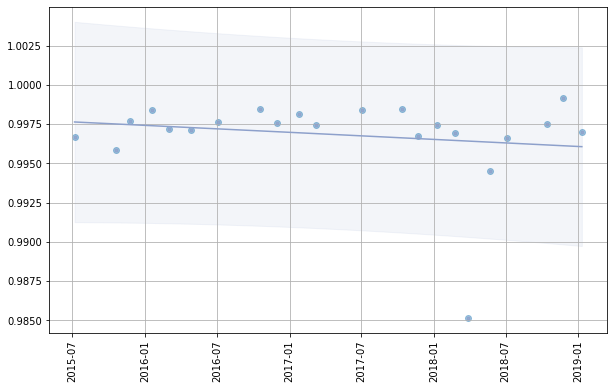

Wall time: 275 ms


In [19]:
%%time
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))
fluct = fluct_anal(g_bow["Conservative"], cosine_sim)
ax.scatter(fluct.index, fluct.values, alpha=0.4)
plot_gam_of_series(fluct, ax)
ax.grid()
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


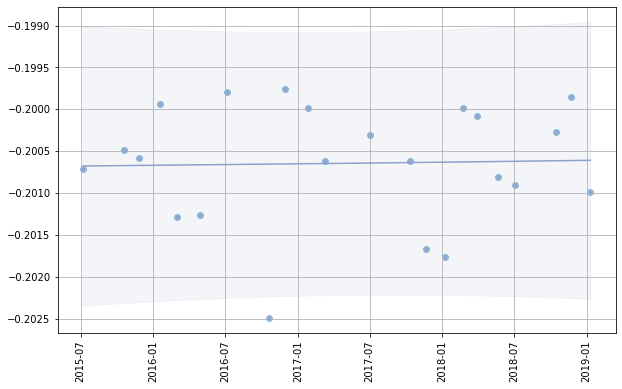

Wall time: 359 ms


In [20]:
%%time
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))

df = g_bow["Conservative"]
df = df.applymap(lambda x: True if x > 0 else False)

fluct = fluct_anal(df, calc_ac1)
ax.scatter(fluct.index, fluct.values, alpha=0.4)
plot_gam_of_series(fluct, ax)
ax.grid()
plt.show()

# Get Keywords at each Window

In [21]:
def get_kw_per_window(contributions, tokens, group_indexes, subset, win_size, win_step, min_freq=10):
    win_counts = {gname: dict() for gname in group_indexes}
    n_words_per_window = {gname: dict() for gname in group_indexes}
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        for gname in group_indexes:
            g_contribs = contribs.loc[contribs.index.isin(group_indexes[gname])]
            g_toks = tokens.loc[g_contribs.index]
            
            curr_counts = get_wordcounts_multiple_texts(g_toks[g_toks.index.isin(subset)])
            
            # Get key words for EU debate
            kw = get_ngram_lr_and_ll(g_toks[g_toks.index.isin(subset)], g_toks[~g_toks.index.isin(subset)], 1)
            
            kw_list = list(kw[kw["LR"] > 1].index)
            kw_list = [k for k in kw_list if curr_counts[k] > min_freq]
            
            win_counts[gname][window] = pd.Series({w: curr_counts[w] for w in kw_list})
            
    win_counts = {g: pd.DataFrame(win_counts[g]).T.fillna(0) for g in group_indexes}
    
    return win_counts

In [22]:
%%time
g_kw_over_time = get_kw_per_window(contributions=all_contributions, tokens=all_toks,
                                   group_indexes={"Conservative": con.index, "Labour": lab.index},
                                   subset=eu_mentions.index, 
                                   win_size=50000, win_step=10000, min_freq=50)

Wall time: 1min 43s


In [23]:
def plot_group_fluct(g_kw_over_time, g_colours, comp_method=calc_ac1, binary=True, ax=None):
    # Make a collocate matrix
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    
    for g in g_kw_over_time:
        df = g_kw_over_time[g]
        if binary:
            df = df.applymap(lambda x: True if x > 0 else False)

        fluct = fluct_anal(df, comp_method)
        ax.scatter(fluct.index, fluct.values, alpha=0.4, color=g_colours[g])
        plot_gam_of_series(fluct, ax, line_colour=g_colours[g], label=g)
    
    if ax is None:
        ax.grid()
        plt.show()

In [26]:
from language_change_methods.fluctuation_analysis import comp_anal

def plot_group_comparison(g1, g2, comp_method=calc_ac1, binary=True, ax=None, colour=None, label=None):
    # Make a collocate matrix
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
    
    if binary:
        df1 = g1.applymap(lambda x: True if x > 0 else False)
        df2 = g2.applymap(lambda x: True if x > 0 else False)
    else:
        df1 = g1
        df2 = g2

    fluct = comp_anal(df1, df2, comp_method)
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color=colour)
    plot_gam_of_series(fluct, ax, line_colour=colour, label=label)
    
    if ax is None:
        ax.grid()
        plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


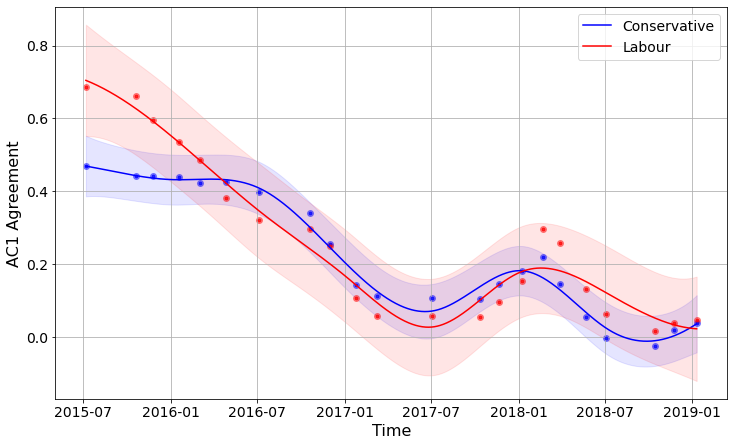

In [27]:
fig, ax = plt.subplots(figsize=(10,6))

plot_group_fluct(g_kw_over_time, {"Conservative": "blue", "Labour": "red"}, ax=ax)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("AC1 Agreement", fontsize=16)
ax.legend(fontsize=14)
plt.tight_layout(pad=0)
ax.grid()
fig.savefig(os.path.join(GRAPH_DIR, "kfa_fluctuation.pdf"))
plt.show()

In [28]:
# %%time
# for mf in [50]:
#     g_kw_over_time = get_kw_per_window(contributions=all_contributions, tokens=all_toks,
#                                        group_indexes={"Conservative": con.index, "Labour": lab.index},
#                                        subset=eu_mentions.index, 
#                                        win_size=50000, win_step=10000, min_freq=mf)
#     plot_group_fluct(g_kw_over_time, {"Conservative": "blue", "Labour": "red"})

### Match Columns of Both DataFrames

In [29]:
from language_change_methods.fluctuation_analysis import add_missing_columns, make_dfs_comparable

In [30]:
df1 = g_kw_over_time["Conservative"]
df2 = g_kw_over_time["Labour"]

df1, df2 = make_dfs_comparable(df1, df2)

df1 = df1 / df1.sum(axis=1).values[:,None]
df2 = df2 / df2.sum(axis=1).values[:,None]

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


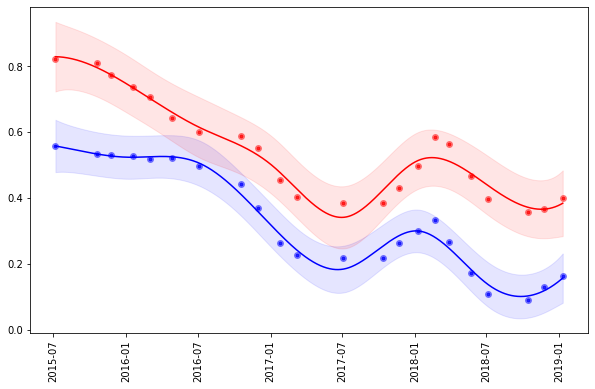

In [31]:
plot_group_fluct({"Conservative": df1, "Labour": df2}, {"Conservative": "blue", "Labour": "red"}, comp_method=calc_ac1, binary=True)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


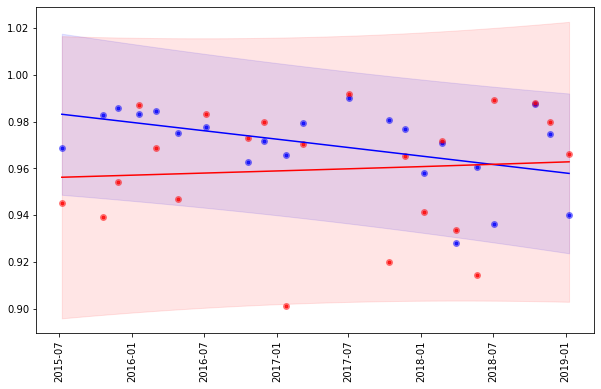

In [32]:
plot_group_fluct({"Conservative": df1, "Labour": df2}, {"Conservative": "blue", "Labour": "red"}, comp_method=cosine_sim, binary=False)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


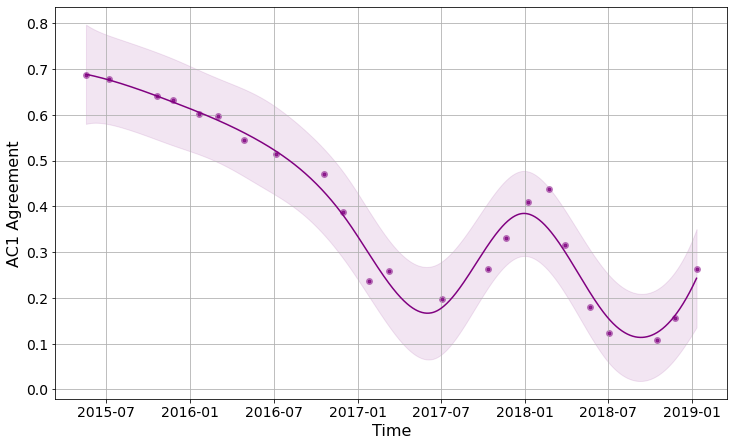

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

plot_group_comparison(df1, df2, comp_method=calc_ac1, binary=True, ax=ax, colour="purple")

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("AC1 Agreement", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()
fig.savefig(os.path.join(GRAPH_DIR, "kfa_comparison.pdf"))
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


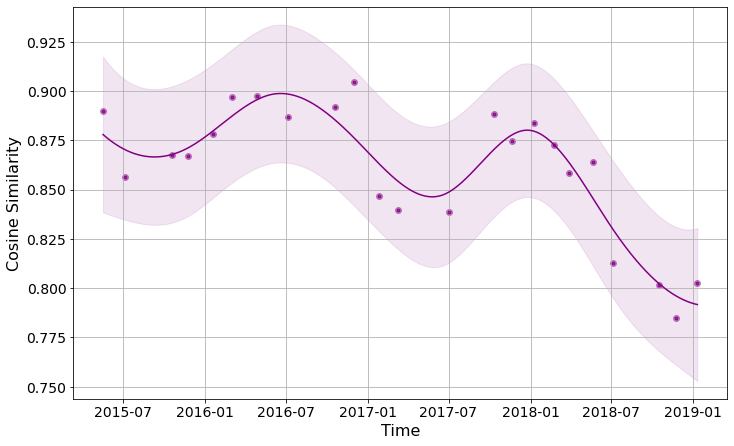

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

plot_group_comparison(df1, df2, comp_method=cosine_sim, binary=False, colour="purple", ax=ax)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Cosine Similarity", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()
fig.savefig(os.path.join(GRAPH_DIR, "kfa_comparison_cosine.pdf"))
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


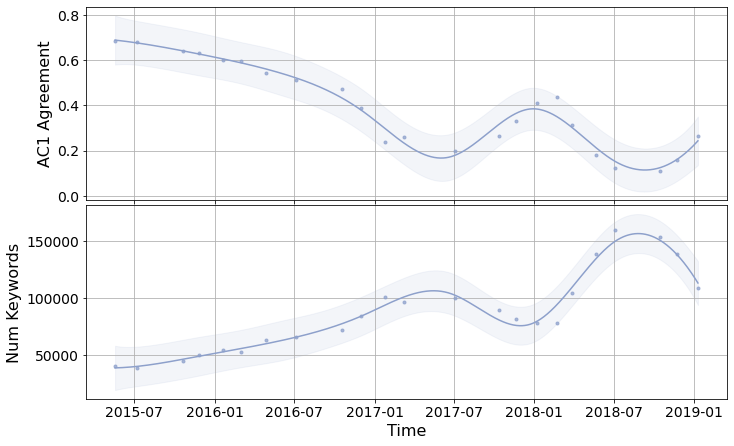

In [35]:
# Make a collocate matrix
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6), sharex=True)


fluct = comp_anal(g_kw_over_time["Conservative"].applymap(lambda x: True if x > 0 else False), 
                  g_kw_over_time["Labour"].applymap(lambda x: True if x > 0 else False), 
                  calc_ac1)
ax.scatter(fluct.index, fluct.values, alpha=0.4)
plot_gam_of_series(fluct, ax1)
plot_gam_of_series(g_kw_over_time["Conservative"].sum(axis=1), ax2)

ax2.xaxis.set_tick_params(labelsize=14, rotation=0)
ax2.yaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.set_xlabel("Time", fontsize=16)
ax2.set_ylabel("Num Keywords", fontsize=16)
ax1.set_ylabel("AC1 Agreement", fontsize=16)

ax1.grid()
ax2.grid()

plt.tight_layout(pad=0)
fig.savefig(os.path.join(GRAPH_DIR, "kfa_comparison_to_num_keywords.pdf"))
plt.show()

## Comparing to a Reference

In [36]:
def create_freq_matrices(contributions, tokens, indices, win_size, win_step, w_list):
    win_counts = dict()
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        g_contribs = contribs.loc[contribs.index.isin(indices)]
        curr_counts = get_wordcounts_multiple_texts(tokens.loc[g_contribs.index])
        curr_counts = pd.Series(curr_counts)
        curr_counts = curr_counts[curr_counts.index.isin(w_list)]
        win_counts[window] = curr_counts
            
    return pd.DataFrame(win_counts).T.fillna(0)

In [37]:
%%time
ref_counts = create_freq_matrices(all_contributions, all_toks, non_eu_mentions.index, 50000, 10000, df1.columns)
ref_counts = make_dfs_comparable(ref_counts, df1)[0]
ref_counts = ref_counts / ref_counts.sum(axis=1).values[:,None]

Wall time: 17.2 s


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


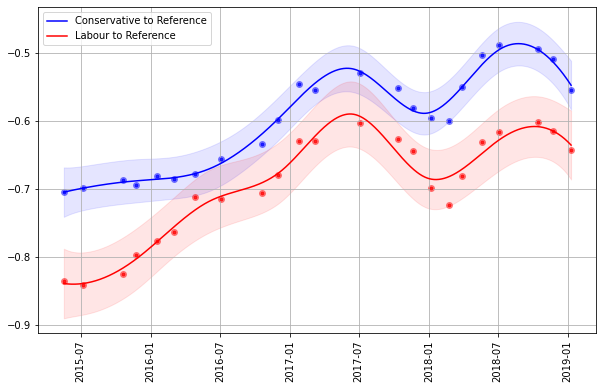

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
plot_group_comparison(df1, ref_counts, comp_method=calc_ac1, binary=True, ax=ax, colour="blue", label="Conservative to Reference")
plot_group_comparison(df2, ref_counts, comp_method=calc_ac1, binary=True, ax=ax, colour="red", label="Labour to Reference")
plt.legend()
ax.grid()
plt.show()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


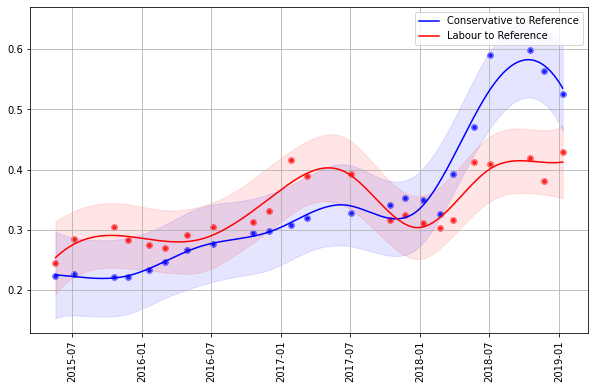

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
plot_group_comparison(df1, ref_counts, comp_method=cosine_sim, binary=False, ax=ax, colour="blue", label="Conservative to Reference")
plot_group_comparison(df2, ref_counts, comp_method=cosine_sim, binary=False, ax=ax, colour="red", label="Labour to Reference")
ax.grid()
plt.legend()
plt.show()

# KFA so both groups have the same features

In [40]:
def get_kw_per_window_same_kws(contributions, tokens, group_indexes, subset, win_size, win_step, min_freq=10):
    win_counts = {gname: dict() for gname in group_indexes}
    
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        w_toks = tokens.loc[contribs.index]
        w_counts  = get_wordcounts_multiple_texts(w_toks[w_toks.index.isin(subset)])
        
        # Get key words for EU debate
        kw = get_ngram_lr_and_ll(w_toks[w_toks.index.isin(subset)], w_toks[~w_toks.index.isin(subset)], 1)

        kw_list = list(kw[kw["LR"] > 1].index)
        kw_list = [k for k in kw_list if w_counts[k] > min_freq]
        
        for gname in group_indexes:
            g_contribs = contribs.loc[contribs.index.isin(group_indexes[gname])]
            g_toks = tokens.loc[g_contribs.index]
            
            g_counts = get_wordcounts_multiple_texts(g_toks[g_toks.index.isin(subset)])
            curr_total = sum(g_counts.values())
            
            win_counts[gname][window] = pd.Series({w: g_counts[w] / curr_total for w in kw_list})
            
    win_counts = {g: pd.DataFrame(win_counts[g]).T.fillna(0) for g in group_indexes}
    
    return win_counts

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Wall time: 2min


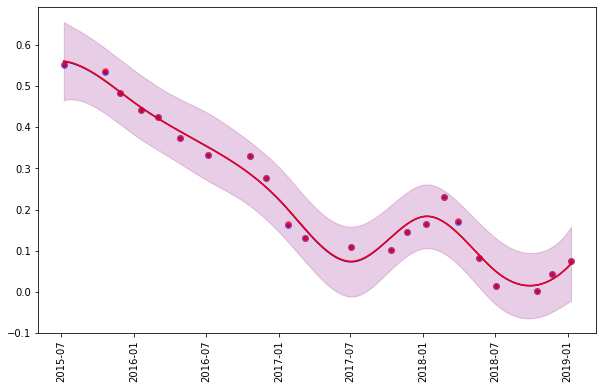

In [41]:
%%time
for mf in [50]:
    g_kw_over_time = get_kw_per_window_same_kws(contributions=all_contributions, tokens=all_toks,
                                                group_indexes={"Conservative": con.index, "Labour": lab.index},
                                                subset=eu_mentions.index, 
                                                win_size=50000, win_step=10000, min_freq=mf)
    plot_group_fluct(g_kw_over_time, {"Conservative": "blue", "Labour": "red"})

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


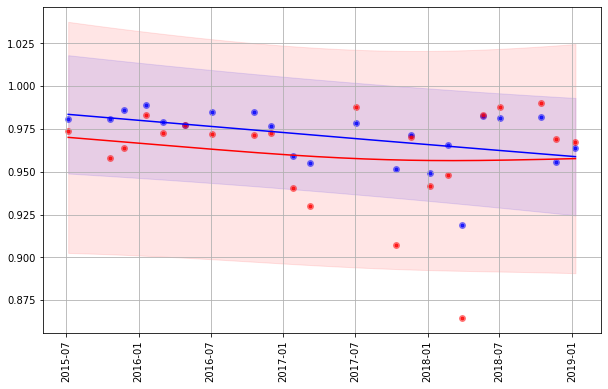

Wall time: 324 ms


In [42]:
%%time
# Make a collocate matrix
fig, ax = plt.subplots(figsize=(10,6))
for g, c in zip(["Conservative", "Labour"], ["blue", "red"]):
    fluct = fluct_anal(g_kw_over_time[g], cosine_sim)
    ax.scatter(fluct.index, fluct.values, alpha=0.4, color=c)
    plot_gam_of_series(fluct, ax, line_colour=c)
ax.grid()
plt.show()

## Fixing it so only keywords of specific group are counted

In [44]:
from language_change_methods.utility_functions import get_log_ratio

In [45]:
def get_kw_per_window_same_kws(contributions, tokens, group_indexes, subset, win_size, win_step, min_freq=10):
    win_counts = {gname: dict() for gname in group_indexes}
    
    for window, contribs in get_data_windows(contributions, win_size, win_step, time_column="date"):
        w_toks = tokens.loc[contribs.index]
        w_counts  = get_wordcounts_multiple_texts(w_toks[w_toks.index.isin(subset)])
        
        # Get key words for EU debate
        kw = get_ngram_lr_and_ll(w_toks[w_toks.index.isin(subset)], w_toks[~w_toks.index.isin(subset)], 1)

        kw_list = list(kw[kw["LR"] > 1].index)
        kw_list = [k for k in kw_list if w_counts[k] > min_freq]
        
        for gname in group_indexes:
            g_contribs = contribs.loc[contribs.index.isin(group_indexes[gname])]
            g_toks = tokens.loc[g_contribs.index]
            
            g_sub_counts = get_wordcounts_multiple_texts(g_toks[g_toks.index.isin(subset)])
            g_oth_counts = get_wordcounts_multiple_texts(g_toks[~g_toks.index.isin(subset)])
            curr_total = sum(g_sub_counts.values())
            
            curr_kws = [w for w in kw_list if get_log_ratio(w, g_sub_counts, g_oth_counts) > 1]
            
            win_counts[gname][window] = pd.Series({w: g_sub_counts[w] / curr_total  if w in curr_kws else 0 for w in kw_list})
            
    win_counts = {g: pd.DataFrame(win_counts[g]).T.fillna(0) for g in group_indexes}
    
    return win_counts

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Wall time: 2min 18s


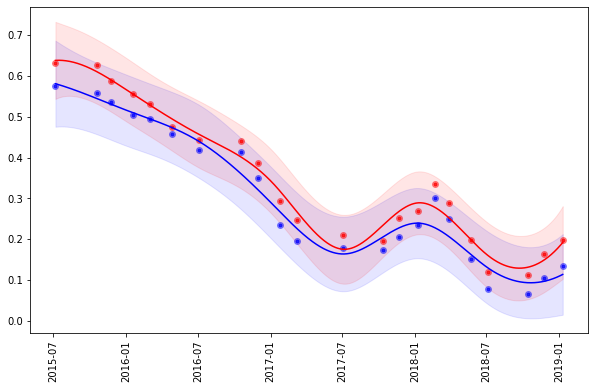

In [46]:
%%time
for mf in [50]:
    g_kw_over_time = get_kw_per_window_same_kws(contributions=all_contributions, tokens=all_toks,
                                                group_indexes={"Conservative": con.index, "Labour": lab.index},
                                                subset=eu_mentions.index, 
                                                win_size=50000, win_step=10000, min_freq=mf)
    plot_group_fluct(g_kw_over_time, {"Conservative": "blue", "Labour": "red"})

In [47]:
g_kw_over_time["Conservative"].applymap(lambda x: True if x > 0 else False)

,NUMBER/,URL,aberavon,aberdeen,abide,abroad,academics,accepting,accession,adequacy,...,world-,worried,wto,wycombe,year-,yellowhammer,yvette,zealand,zero,zero-
2015-05-18,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2015-07-07,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2015-10-20,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2015-11-25,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2016-01-19,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2016-03-02,False,False,False,False,False,True,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2016-04-27,False,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2016-07-05,False,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2016-10-19,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2016-11-30,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


In [48]:
g_kw_over_time["Conservative"].applymap(lambda x: True if x > 0 else False)

,NUMBER/,URL,aberavon,aberdeen,abide,abroad,academics,accepting,accession,adequacy,...,world-,worried,wto,wycombe,year-,yellowhammer,yvette,zealand,zero,zero-
2015-05-18,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2015-07-07,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2015-10-20,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2015-11-25,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2016-01-19,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2016-03-02,False,False,False,False,False,True,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2016-04-27,False,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2016-07-05,False,False,False,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2016-10-19,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2016-11-30,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


## Comparing Groups

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


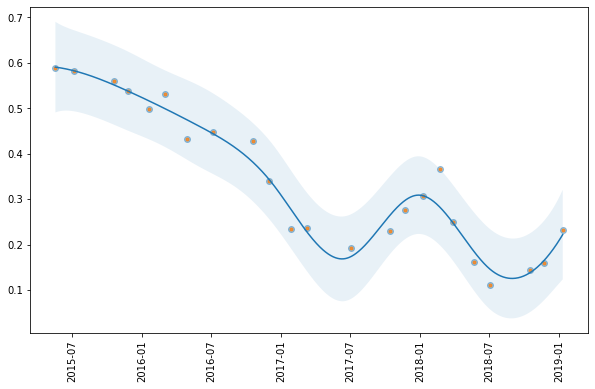

In [49]:
plot_group_comparison(g_kw_over_time["Conservative"], g_kw_over_time["Conservative"])

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


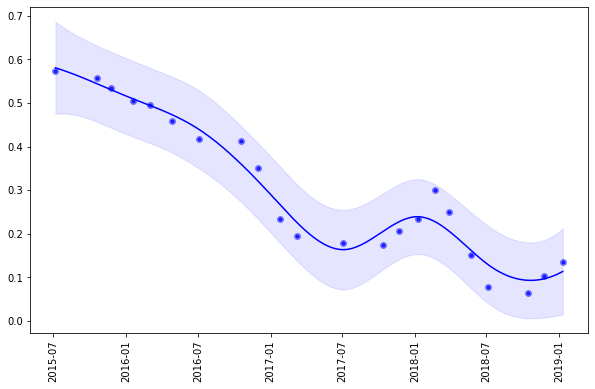

In [50]:
plot_group_fluct({"Conservative": g_kw_over_time["Conservative"]}, {"Conservative": "blue"})

In [51]:
df1 = g_kw_over_time["Conservative"].applymap(lambda x: True if x > 0 else False)
df2 = g_kw_over_time["Labour"].applymap(lambda x: True if x > 0 else False)

fluct = comp_anal(df1, df2, calc_ac1)

<AxesSubplot:>

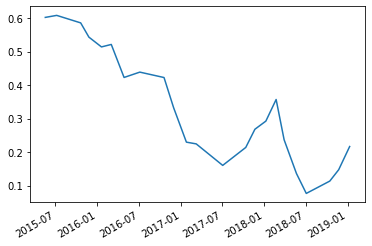

In [52]:
fluct.plot()

<AxesSubplot:>

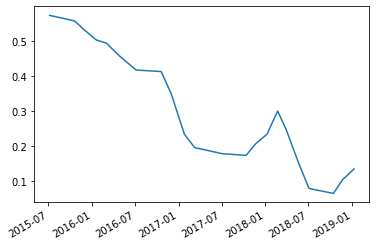

In [53]:
fluct_anal(df1, calc_ac1).plot()

In [54]:
for d, currow in (df1 == df2).applymap(int).sum(axis=1).items():
    print(d, currow, df1.shape[1], currow / df1.shape[1])

2015-05-18 00:00:00 1194 1238 0.9644588045234249
2015-07-07 00:00:00 1192 1238 0.962843295638126
2015-10-20 00:00:00 1182 1238 0.9547657512116317
2015-11-25 00:00:00 1159 1238 0.9361873990306947
2016-01-19 00:00:00 1159 1238 0.9361873990306947
2016-03-02 00:00:00 1165 1238 0.9410339256865913
2016-04-27 00:00:00 1154 1238 0.9321486268174475
2016-07-05 00:00:00 1146 1238 0.925686591276252
2016-10-19 00:00:00 1165 1238 0.9410339256865913
2016-11-30 00:00:00 1153 1238 0.931340872374798
2017-01-25 00:00:00 1129 1238 0.9119547657512116
2017-03-09 00:00:00 1137 1238 0.9184168012924071
2017-07-03 00:00:00 1129 1238 0.9119547657512116
2017-10-12 00:00:00 1132 1238 0.9143780290791599
2017-11-21 00:00:00 1159 1238 0.9361873990306947
2018-01-08 00:00:00 1158 1238 0.9353796445880452
2018-02-22 00:00:00 1155 1238 0.932956381260097
2018-03-29 00:00:00 1135 1238 0.9168012924071083
2018-05-22 00:00:00 1120 1238 0.9046849757673667
2018-07-04 00:00:00 1109 1238 0.8957996768982229
2018-10-15 00:00:00 1107

<AxesSubplot:>

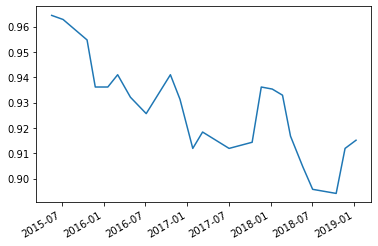

In [55]:
((df1 == df2).applymap(int).sum(axis=1) / df1.shape[1]).plot()